In [1]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

In [2]:
# Define the Class of Network
# 输入为当前的状态， 输出为所有动作的q value，所以需要知道当前状态的维度和动作的维度
class Network(nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.tensor:
        return self.layers(x)

In [3]:
env = gym.make("CartPole-v1", max_episode_steps=200, render_mode="rgb_array")

In [4]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [5]:
env.action_space.n

2

In [6]:
# 设计replay存贮机制，需要存储的数据分别为当前状态，下个状态，动作，奖励，游戏是否结束
# 考虑使用ndarray 数据结构存储数据
# 需要设计存储新数据的方法和批次抽样方法
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        # update pointer, 如果超过了最大容量，就开始覆盖数据
        self.ptr = (self.ptr + 1) % self.max_size
        # 如果装满了，计数器就一直维持在最大容量值
        self.size = min(self.size + 1, self.max_size)
        
    #使用字典的形式来存储这一批样本
    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

In [17]:
# Define the Class of DQN
class DQNAgent:

    def __init__(
            self,
            env: gym.Env,
            memory_size: int,
            batch_size: int,
            epsilon_decay: float,
            target_update: int,
            seed: int,
            max_epsilon: float=1.0,
            min_epsilon: float=0.1,
            gamma: float=0.99
            ):
        
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.env = env
        self.batch_size = batch_size
        self.epsilon_decay = epsilon_decay
        self.seed = seed
        self.epsilon = max_epsilon
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.target_dqn = Network(obs_dim, action_dim).to(self.device)
        self.target_dqn.load_state_dict(self.dqn.state_dict())
        self.target_dqn.eval()

        self.optimizer = optim.Adam(self.dqn.parameters())
        self.transition = list()
        self.is_test = False

    def select_action(self, state: np.ndarray):

        if self.epsilon > np.random.random():
            cur_action = self.env.action_space.sample()
        else:
            cur_action = self.dqn(torch.tensor(state).to(self.device)).argmax()
            # cur_action = cur_action.detach().cpu().numpy()
            cur_action = cur_action.detach().numpy()
        if not self.is_test:
            self.transition = [state, cur_action]

        return cur_action
    
    # return new_state, reward, done
    # 使用一个缓存器，存储一个样本，然后再将样本存到replaybuff中
    def step(self, action):

        self.env.step(action)
        new_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        if not self.is_test:
            self.transition += [reward, new_state, done]
            self.memory.store(*self.transition)

        return new_state, reward, done
    
    def update_model(self):

        samples = self.memory.sample_batch()
        loss = self._compute_dqn_loss(samples)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def train(self, num_frames, plotting_interval: int = 200 ):

        self.is_test = False
        state, _ = self.env.reset(seed=self.seed)
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames+1):
            #train model and record mid_result
            #1. 先生成足够一个batch的样本
            #2. 生成之后一边网络更新，一边生成新的样本
            cur_action = self.select_action(state)
            new_state, reward, done = self.step(cur_action)
            state = new_state
            score += reward

            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0

            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1

                self.epsilon = max(self.min_epsilon, self.epsilon - (self.max_epsilon - self.min_epsilon) * self.epsilon_decay)
                epsilons.append(self.epsilon)

                if update_cnt % self.target_update == 0:
                    self._target_hard_update()
                    
            if frame_idx % plotting_interval == 0:
                self.plot(frame_idx, scores, losses, epsilons)

        self.env.close()

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]):
        device = self.device
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1,1)).to(device)
        # print(action)
        reward = torch.FloatTensor(samples["rews"].reshape(-1,1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, )).to(device)

        cur_q_value = self.dqn(state).gather(1, action)
        # print(cur_q_value)
        # next_q_value = self.target_dqn(next_state).max(dim=1, keepdim=True)[0].detach()
        next_q_value = self.target_dqn(next_state).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        loss = F.smooth_l1_loss(cur_q_value, target)

        return loss

    def _target_hard_update(self):
        self.target_dqn.load_state_dict(self.dqn.state_dict())

    def plot(self, frame_idx, scores, losses, epsilons):
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()
        
    def test(self, video_folder: str) -> None:
        """Test the agent."""
        self.is_test = True
        
        # for recording a video
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)
        
        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0
        
        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        # reset
        self.env = naive_env


        

In [18]:
env = gym.make("CartPole-v1", max_episode_steps=200, render_mode="rgb_array")

In [19]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

In [20]:
# parameters
num_frames = 10000
memory_size = 1000
batch_size = 32
target_update = 100
epsilon_decay = 1 / 2000

agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay, seed)

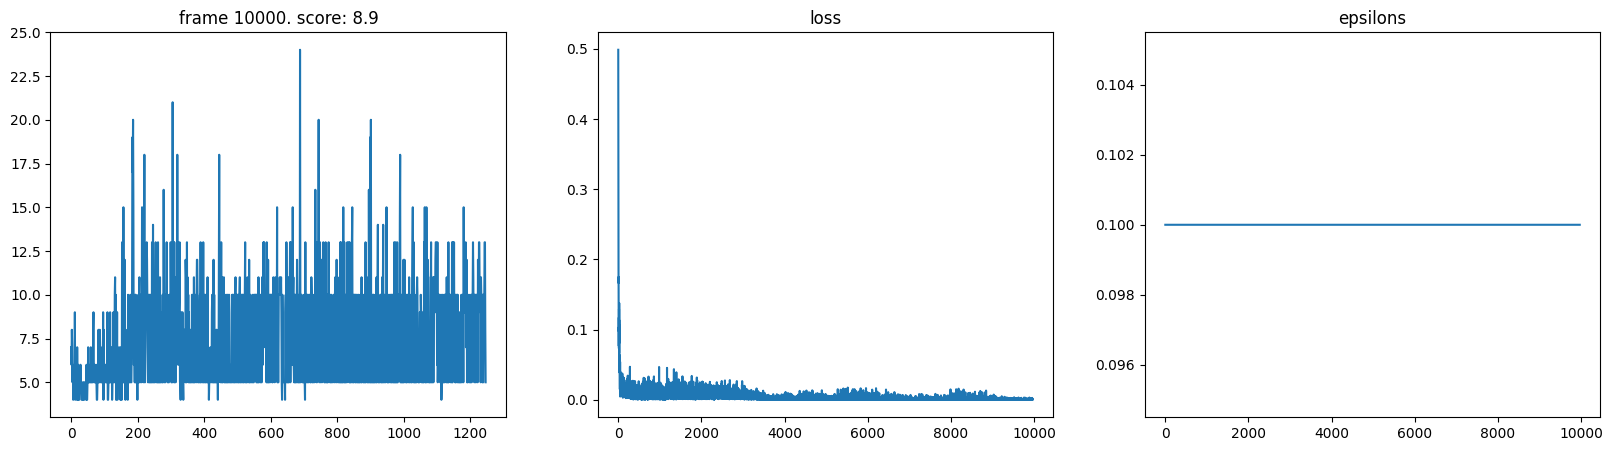

In [21]:
agent.train(num_frames)

In [31]:
video_folder="videos/dqn"
agent.test(video_folder=video_folder)

Unexpected exception formatting exception. Falling back to standard exception


/opt/homebrew/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /Users/magi/Deep_RL_implementation/videos/dqn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.9/site-packages/gymnasium/wrappers/monitoring/video_recorder.py", line 45, in __init__
    import moviepy  # noqa: F401
ModuleNotFoundError: No module named 'moviepy'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/v1/6w9qlgx10wv239bq41hlsstc0000gn/T/ipykernel_44962/1250899412.py", line 2, in <module>
    agent.test(video_folder=video_folder)
  File "/var/folders/v1/6w9qlgx10wv239bq41hlsstc0